In [5]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [6]:
# Base URL
base_url = 'https://api.biorxiv.org/pub/'
start_date = '2015-01-01'
end_date = '2020-10-31'

In [7]:
# load data
raw = pd.read_json('biorxiv_published_' + start_date + 'to' + end_date + '.json')

# Clean data
1) Remove weird date entries

2) Convert categoreis to all lower case

3) Convert date strings to datetime

In [8]:
# remove weird entries for published date (can try to fix, but currently only 16 entries)
s = raw['published_date'].apply(len)
ind = np.flatnonzero(s != 10)
print(f"{len(ind)} entries removed")
data = raw.drop(raw.index[ind])

17 entries removed


In [9]:
# remove rows where doi does not start with 1
good_doi = data.published_doi.str.startswith('1')
print(f"{data.shape[0]-good_doi.sum()} entries removed")

data = data[good_doi]

12 entries removed


In [10]:
# make all categories lower case
data['preprint_category'] = data.preprint_category.str.lower()

In [11]:
# convert date columns from strings to datetime
data['published_date'] = pd.to_datetime(data['published_date'],format = '%Y-%m-%d')
data['preprint_date'] = pd.to_datetime(data['preprint_date'],format = '%Y-%m-%d')

### Feature engineering
1) add a 'days_to_publish' column with difference between preprint date and published date

2) add a 'pub_prefix' column to extract the publisher prefix from the doi

3) convert the publisher prefix to the name of publication using a look-up table

In [12]:
# add days to publish column
data['days_to_publish'] = (data['published_date'] - data['preprint_date'])/ pd.to_timedelta(1, unit='D')

# add pub prefix column
data['pub_prefix'] = data.published_doi.str.split('/',expand=True)[0]


In [13]:
# load look up table for dois
doi_lut = pd.read_csv('doi-prefix-publishers.csv')

# convert publisher prefixes in data to floats to compare
prefs = data.pub_prefix.astype(float)

In [14]:
# create dictionary to replace publication prefix with publication
prefix_lut = {}
for prefix in prefs.unique():
    pub = doi_lut[doi_lut['prefix'] == prefix].publisher.values
    if pub.shape[0] == 1:
        prefix_lut[str(prefix)] = pub[0]
    else:
        prefix_lut[str(prefix)] = str(prefix)


In [15]:
data['pub_name'] = data['pub_prefix'].copy()
data['pub_name'] = data['pub_name'].replace(prefix_lut)
data.head()

,biorxiv_doi,published_doi,preprint_title,preprint_category,preprint_date,published_date,published_citation_count,days_to_publish,pub_prefix,pub_name
0,10.1101/007898,10.1016/j.fsigen.2014.09.005,Facile semi-automated forensic body fluid iden...,genomics,2014-08-12,2015-01-01,9,142.0,10.1016,Elsevier
1,10.1101/006742,10.1101/gr.178756.114,Efficient inference of population size histori...,evolutionary biology,2014-06-28,2015-01-06,21,192.0,10.1101,Cold Spring Harbor Laboratory Press
2,10.1101/007922,10.1073/pnas.1413877112,Shadow enhancers enable Hunchback bifunctional...,systems biology,2014-08-13,2015-01-06,18,146.0,10.1073,Proceedings of the National Academy of Sciences
3,10.1101/006908,10.1093/nar/gku1392,Recurrent alternative splicing isoform switche...,bioinformatics,2014-07-04,2015-01-10,49,190.0,10.1093,Oxford University Press
4,10.1101/007963,10.1093/bioinformatics/btv002,RNA-Rocket: An RNA-Seq Analysis Resource for I...,bioinformatics,2014-08-14,2015-01-07,8,146.0,10.1093,Oxford University Press


In [20]:
# save preprocessed data
data.to_json('preprints_prep.json')

In [16]:
# separate neuro data from the rest
neuro_data = data[data['preprint_category']=='neuroscience']
neuro_data.shape

(7621, 10)

### Plot things

Text(0, 0.5, '# of preprints')

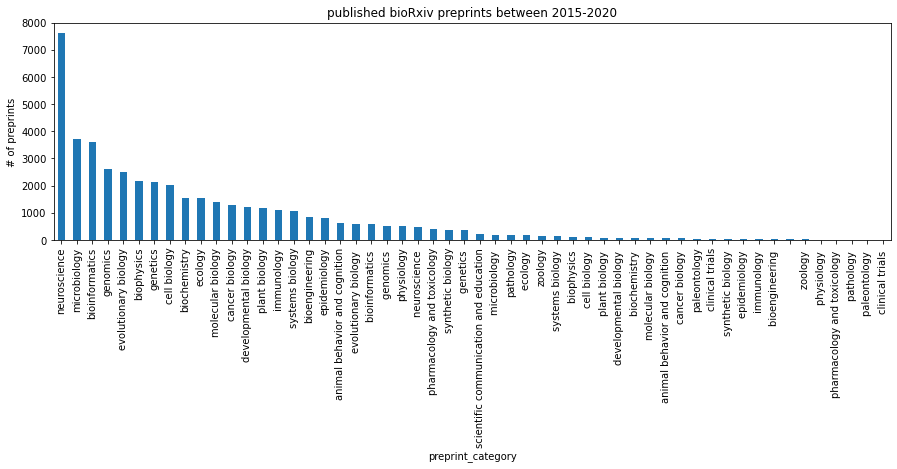

In [17]:
# plot # of preprints published by field
plt.figure(figsize=(15,4))
data.groupby(data.preprint_category).biorxiv_doi.count().sort_values(ascending = False).plot.bar()
plt.title('published bioRxiv preprints between 2015-2020')
plt.ylabel('# of preprints')

Text(0, 0.5, 'days')

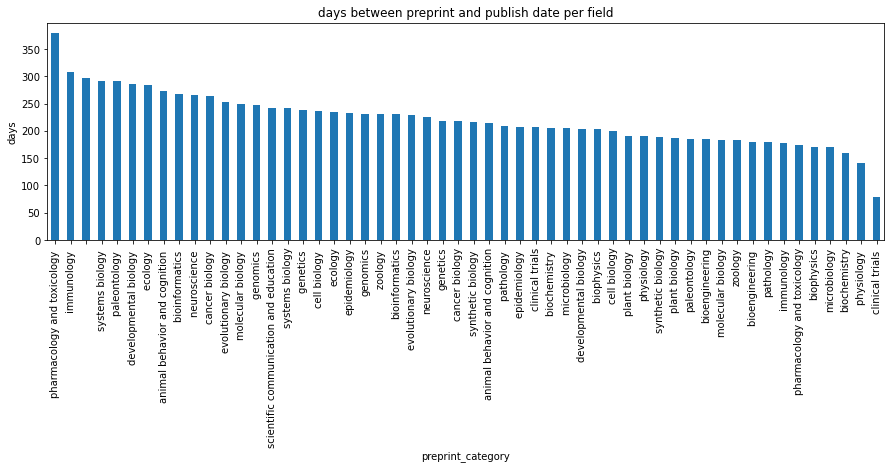

In [14]:
# plot length to publish per field
plt.figure(figsize=(15,4))
data.groupby(data.preprint_category).days_to_publish.mean().sort_values(ascending = False).plot.bar()
plt.title('days between preprint and publish date per field')
plt.ylabel('days')

Text(0, 0.5, 'days')

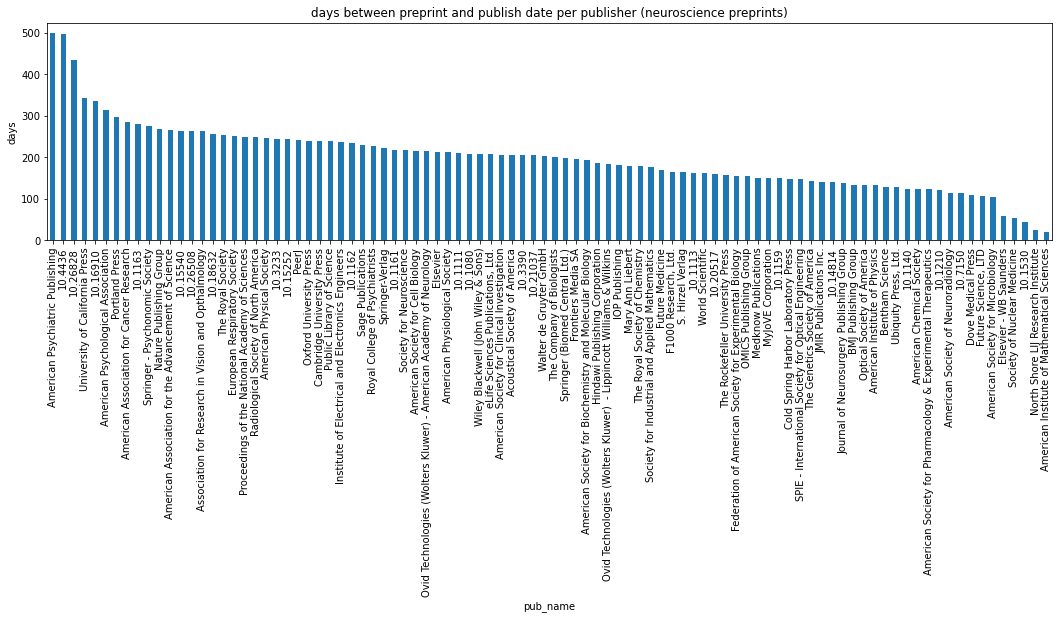

In [16]:
# plot length to publish per publisher
plt.figure(figsize=(18,4))
neuro_data.groupby(neuro_data.pub_name).days_to_publish.mean().sort_values(ascending = False).plot.bar()
plt.title('days between preprint and publish date per publisher (neuroscience preprints)')
plt.ylabel('days')